In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ExternalFunctions import Chi2Regression

from scipy import stats
from iminuit import Minuit                             # The actual fitting tool, better than scipy's

In [2]:
def f(t, tau):
    return 1/tau * np.exp(-t/tau)

def F_inverted(p, tau):
    """p should be uniform random numbers"""
    return -tau * np.log(1 - p)

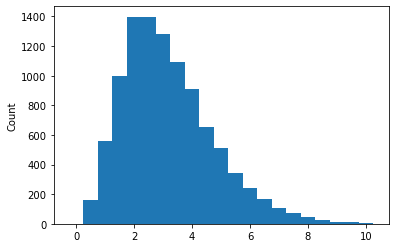

In [3]:
np.random.seed(seed=42)

tau = 0.8
Nrand = 10000 # Number of random numbers to generate

u = np.zeros(Nrand)

# generate uniform random numbers
for i in range(4):
    p = np.random.uniform(size=Nrand)
    #plt.hist(p,bins=bins)
    #plt.show()
    t = F_inverted(p, tau)
    #plt.hist(t,bins=bins)
    #plt.show()
    u += t
    
fig1, ax1 = plt.subplots()
# Set up the bins in a smart way
Nbins = 20+1
my_range = (-0.25, (Nbins-1)/2 + 0.25)

counts, bin_edges, garbage = ax1.hist(u, bins=Nbins, range=my_range)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

ax1.set_ylabel('Count')
plt.show()

In [4]:
print(bin_centers)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


In [5]:
def pearson_chi2(count_measured, count_model):
    chi2_value = 0
    for i in range(len(count_measured)):
        chi2_value += (count_measured[i] - count_model[i])**2/count_model[i]
    
    #chi2_value = np.sum( (count_measured - count_model)**2/count_model)
    return chi2_value


# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

def gauss_extended(x, N, mu, sigma):
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2098                       │              Nfcn = 97               │
│ EDM = 9.82e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  3.95e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ mu    │   3.139   │   0.023   │            │            │         │         │       │
│ 2 │ sigma │   1.057   │   0.010   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        N       mu    sigma │
├───────┼────────────────────────────┤
│     N │ 2.05e+03  -0.0285  -0.0144 │
│    mu │  -0.0285 0.000505 0.000189 │
│ sigma │  -0.0144 0.000189 9.84e-05 │
└───────┴────────────────────────────┘

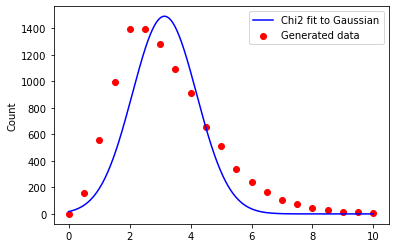

Chi2 value: 2097.5   Ndof = 18    Prob(Chi2,Ndof) = 0.000


In [6]:
#chi2 = Chi2Regression(gaus_extended, x, y, sy)
#chi2.errordef = 1
#minuit = Minuit(chi2, N=N_experiments, n=N_trials, p=p_success) #   
#minuit.migrad()          # Perform the actual fit

fig2, ax2 = plt.subplots()
ax2.scatter(bin_centers, counts, color='red', label='Generated data')

# Do a Pearson chi2 reduction
#minuit = Minuit(pearson_chi2(counts, gauss_extended(bin_centers, N, mu, sigma)), N=Nrand, mu=3, sigma=2)

# Do a Pearson chi2 reduction, i.e. y_err = sqrt(y)
chi2 = Chi2Regression(gauss_extended, bin_centers, counts, np.sqrt(counts))
chi2.errordef = 1
minuit_chi2 = Minuit(chi2, N=Nrand, mu=3, sigma=2) #   
display(minuit_chi2.migrad())          # Perform the actual fit

N_fit = minuit_chi2.values[0]
mu_fit = minuit_chi2.values[1]
sigma_fit = minuit_chi2.values[2]

t = np.linspace(0,10,1000)

ax2.plot(t, gauss_extended(t, N_fit, mu_fit, sigma_fit), color='blue', label='Chi2 fit to Gaussian')

ax2.set_ylabel('Count')
ax2.legend()
plt.show()

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(counts > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

chi2_value = minuit_chi2.fval
p_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {p_value:5.3f}")

Try with normalized bins

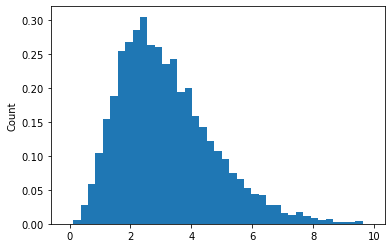

../External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = inf                        │              Nfcn = 66               │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │     3     │    nan    │            │            │         │         │       │
│ 1 │ sigma │     2     │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────┐
│       │    mu sigma │
├───────┼─────────────┤
│    mu │   nan   nan │
│ sigma │   nan   nan │
└───────┴─────────────┘

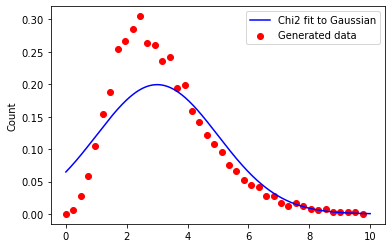

Chi2 value: inf   Ndof = 38    Prob(Chi2,Ndof) = 0.000


In [9]:
np.random.seed(seed=42)

tau = 0.8
Nrand = 10000 # Number of random numbers to generate

u = np.zeros(Nrand)

# generate uniform random numbers
for i in range(4):
    p = np.random.uniform(size=Nrand)
    #plt.hist(p,bins=bins)
    #plt.show()
    t = F_inverted(p, tau)
    #plt.hist(t,bins=bins)
    #plt.show()
    u += t
    
fig1, ax1 = plt.subplots()
# Set up the bins in a smart way
Nbins = 40+1
my_range = (-0.25/2, (Nbins/2-1)/2 + 0.25/2)

counts, bin_edges, garbage = ax1.hist(u, bins=Nbins, range=my_range, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

ax1.set_ylabel('Count')
plt.show()

fig2, ax2 = plt.subplots()
ax2.scatter(bin_centers, counts, color='red', label='Generated data')

# Do a Pearson chi2 reduction
#minuit = Minuit(pearson_chi2(counts, gauss_extended(bin_centers, N, mu, sigma)), N=Nrand, mu=3, sigma=2)

# Do a Pearson chi2 reduction, i.e. y_err = sqrt(y)
chi2 = Chi2Regression(gauss_pdf, bin_centers, counts, np.sqrt(counts))
chi2.errordef = 1
minuit_chi2 = Minuit(chi2, mu=3, sigma=2) #   
display(minuit_chi2.migrad())          # Perform the actual fit

mu_fit = minuit_chi2.values[0]
sigma_fit = minuit_chi2.values[1]

t = np.linspace(0,10,1000)

ax2.plot(t, gauss_pdf(t, mu_fit, sigma_fit), color='blue', label='Chi2 fit to Gaussian')

ax2.set_ylabel('Count')
ax2.legend()
plt.show()

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(counts > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

chi2_value = minuit_chi2.fval
p_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {p_value:5.3f}")